In [1]:
##training and performance evaluation of classification data for credit default
#this is not as detailed see Regression Training code file more explanation and detail
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Split the data into predictors and prediction
y = df['stroke']

# Preprocessing
# Drop columns from the dataframe that are not relevant. Stroke needs to be removed to isolate the prediction, BMI has missing variables, and ID is not a valid predictor
df = df.drop(columns=['stroke','bmi', 'id'], axis=1)



In [4]:
# Create dummy variables first (as in previous example)
categorical_cols = df.select_dtypes(include=['object']).columns
df_dummy = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   gender_Male                     5110 non-null   bool   
 5   gender_Other                    5110 non-null   bool   
 6   ever_married_Yes                5110 non-null   bool   
 7   work_type_Never_worked          5110 non-null   bool   
 8   work_type_Private               5110 non-null   bool   
 9   work_type_Self-employed         5110 non-null   bool   
 10  work_type_children              5110 non-null   bool   
 11  Residence_type_Urban            5110 non-null   bool   
 12  smoking_status_formerly smoked  51

In [5]:
from sklearn.preprocessing import StandardScaler

#lets scale the predictors (z-score
scaler = StandardScaler()  #create instance of scaler
df_dummy_std = scaler.fit_transform(df_dummy)

#we now have a standardzied dataset nearly ready for analysis
#its also no longer a panda dataframe but a numpy array

#for now lets convert it back to pandas data frame, using column name/index from previous dataframe and save it as X our predictors
X = pd.DataFrame(df_dummy_std, columns = df_dummy.columns, index= df_dummy.index)


In [6]:
# Print class distribution (notice how imbalanced it is! take note you may need strategies to counteract or there will be a strong bias towards the majority class0
print("\nClass Distribution:")
print(y.value_counts(normalize=True))


Class Distribution:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


In [7]:
##jump[ into training

# Initialize 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
cv_results = {
    'Logistic Regression': [],
    'KNN': [],
    'Decision Tree': [],
    'Random Forest': [],
    'Gradient Boosting': [],
    'Neural Network': []
}

In [8]:
##some functions to summarize performance of models
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot a stylized confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate and print metrics
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # Sensitivity/Recall
    tnr = tn / (tn + fp)  # Specificity
    precision = tp / (tp + fp)
    f1 = 2 * (precision * tpr) / (precision + tpr)

    print(f"\nMetrics for {title}:")
    print(f"True Positive Rate (Sensitivity/Recall): {tpr:.3f}")
    print(f"True Negative Rate (Specificity): {tnr:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.3f}")

In [9]:
##thats a bit custom lets create twho functions we can apply to any GridSearchCV object and return a summary of the paramter perfgormance and a plot of it

def analyze_grid_performance(grid_cv, score_name='Balanced Accuracy'):
    """
    Create a performance table for GridSearchCV results

    Parameters:
    -----------
    grid_cv : GridSearchCV object
        Fitted GridSearchCV object
    score_name : str, default='RMSE'
        Name of the score metric for display

    Returns:
    --------
    pd.DataFrame
        Table with all parameter combinations and their performance metrics
    """
    # Convert results to DataFrame
    results = pd.DataFrame(grid_cv.cv_results_)

    # Get parameter columns
    param_cols = [col for col in results.columns if col.startswith('param_')]

    # Create performance table
    performance_table = pd.DataFrame({
        # Extract parameter name from 'param_*' and create columns
        param.replace('param_', ''): results[param]
        for param in param_cols
    })

    # Add performance metrics
    performance_table[f'Mean {score_name}'] = -results['mean_test_score']
    performance_table[f'Std {score_name}'] = results['std_test_score']

    # Get number of splits from the CV object
    n_splits = grid_cv.cv.n_splits
    performance_table[f'SE {score_name}'] = results['std_test_score'] / np.sqrt(n_splits)

    performance_table['Rank'] = results['rank_test_score']

    # Sort by performance (assuming lower score is better, like RMSE)
    performance_table = performance_table.sort_values(by=f'Mean {score_name}')

    # Reset index for clean display
    performance_table = performance_table.reset_index(drop=True)

    return performance_table

def plot_grid_performance(grid_cv, score_name='Balanced Accuracy', top_n=10):
    """
    Plot performance for top N parameter combinations

    Parameters:
    -----------
    grid_cv : GridSearchCV object
        Fitted GridSearchCV object
    score_name : str, default='RMSE'
        Name of the score metric for display
    top_n : int, default=10
        Number of top performing combinations to show
    """
    # Get performance table
    perf_table = analyze_grid_performance(grid_cv, score_name)

    # Get parameter names
    param_names = [col for col in perf_table.columns
                  if col not in [f'Mean {score_name}', f'Std {score_name}',
                               f'SE {score_name}', 'Rank']]

    # Create parameter combination strings for top N
    top_n_combos = perf_table.head(top_n).apply(
        lambda row: '\n'.join(f"{param}: {row[param]}"
                            for param in param_names),
        axis=1
    )

    # Create plot with specific size ratio
    plt.figure(figsize=(12, 8))

    # Create error bar plot
    plt.errorbar(
        perf_table[f'Mean {score_name}'].head(top_n),
        range(top_n),
        xerr=perf_table[f'SE {score_name}'].head(top_n),
        fmt='o',
        capsize=5,  # Add caps to error bars
        markersize=8,  # Larger points
        elinewidth=2,  # Thicker error bars
        capthick=2  # Thicker caps
    )

    # Add vertical gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Customize appearance
    plt.yticks(range(top_n), top_n_combos, ha='right')
    plt.title(f'Top {top_n} Parameter Combinations\n(Error bars = ±1 SE)',
             pad=20,
             fontsize=12)
    plt.xlabel(f'{score_name} (lower is better)', fontsize=10)

    # Add text showing n_splits used for SE calculation
    n_splits = grid_cv.cv.n_splits
    plt.figtext(0.99, 0.01,
                f'SE calculated using {n_splits}-fold CV',
                ha='right',
                fontsize=8,
                style='italic')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Print top N performance metrics
    print(f"\nTop {top_n} Performance Details:")
    detail_cols = [col for col in perf_table.columns
                  if any(x in col for x in [score_name, 'Rank'])]
    print(perf_table[detail_cols].head(top_n).round(3))

In [10]:
# Fitting logistic regression
lr = LogisticRegression(class_weight='balanced')
cv_results['Logistic Regression'] = cross_val_score(lr, X, y,
                                                  scoring='balanced_accuracy',
                                                  cv=kf)

# Fit on full data for feature importance
lr.fit(X, y)
print("\nLogistic Regression Coefficients:")
for feat, coef in zip(X.columns, lr.coef_[0]):
    print(f"{feat}: {coef:.2f}")




Logistic Regression Coefficients:
age: 1.78
hypertension: 0.16
heart_disease: 0.07
avg_glucose_level: 0.18
gender_Male: -0.06
gender_Other: -0.06
ever_married_Yes: -0.01
work_type_Never_worked: -0.20
work_type_Private: 0.09
work_type_Self-employed: -0.04
work_type_children: 0.47
Residence_type_Urban: 0.05
smoking_status_formerly smoked: 0.05
smoking_status_never smoked: -0.11
smoking_status_smokes: 0.08


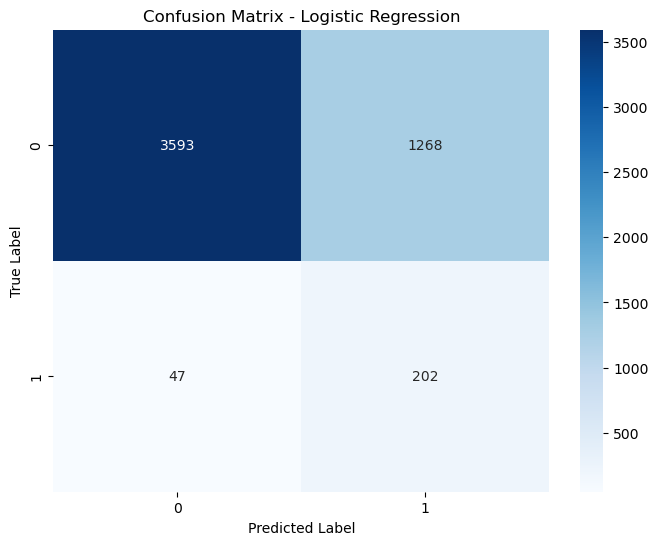


Metrics for Logistic Regression:
True Positive Rate (Sensitivity/Recall): 0.811
True Negative Rate (Specificity): 0.739
Precision: 0.137
F1 Score: 0.235
Balanced Accuracy: 0.775


In [11]:
# Plot confusion matrix for logistic regression
y_pred_lr = lr.predict(X)
plot_confusion_matrix(y, y_pred_lr, "Logistic Regression")

In [12]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['Logistic Regression'])
std_score = np.std(cv_results['Logistic Regression'])
print(f"Logistic Regression Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

Logistic Regression Performance - Balanced Accuracy Mean: 0.770 Std Dev: 0.039)


In [13]:
##knn

# KNN with Grid Search
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

knn.fit(X, y)
cv_results['KNN'] = cross_val_score(knn.best_estimator_, X, y,
                                   scoring='balanced_accuracy',
                                   cv=kf)


Best kn Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


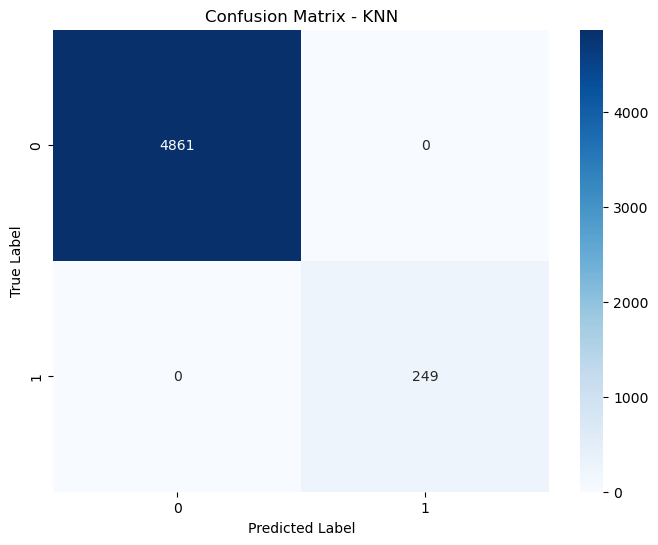


Metrics for KNN:
True Positive Rate (Sensitivity/Recall): 1.000
True Negative Rate (Specificity): 1.000
Precision: 1.000
F1 Score: 1.000
Balanced Accuracy: 1.000


In [14]:
print("\nBest kn Parameters:", knn.best_params_)
y_pred_knn = knn.predict(X)
plot_confusion_matrix(y, y_pred_knn, "KNN")

In [15]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['KNN'])
std_score = np.std(cv_results['KNN'])
print(f"KNN Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

KNN Performance - Balanced Accuracy Mean: 0.538 Std Dev: 0.035)



KNN Performance Table:
       metric  n_neighbors   weights  Mean Balanced Accuracy  \
0   euclidean            3  distance               -0.537687   
1   manhattan            3  distance               -0.534139   
2   manhattan            5  distance               -0.530616   
3   euclidean            5  distance               -0.529027   
4   euclidean            3   uniform               -0.528182   
5   manhattan            3   uniform               -0.526527   
6   manhattan            7  distance               -0.523373   
7   manhattan            9  distance               -0.523056   
8   euclidean            7  distance               -0.522250   
9   euclidean            9  distance               -0.517021   
10  manhattan            5   uniform               -0.516860   
11  euclidean            5   uniform               -0.515209   
12  manhattan            7   uniform               -0.512305   
13  manhattan            9   uniform               -0.507199   
14  euclidean   

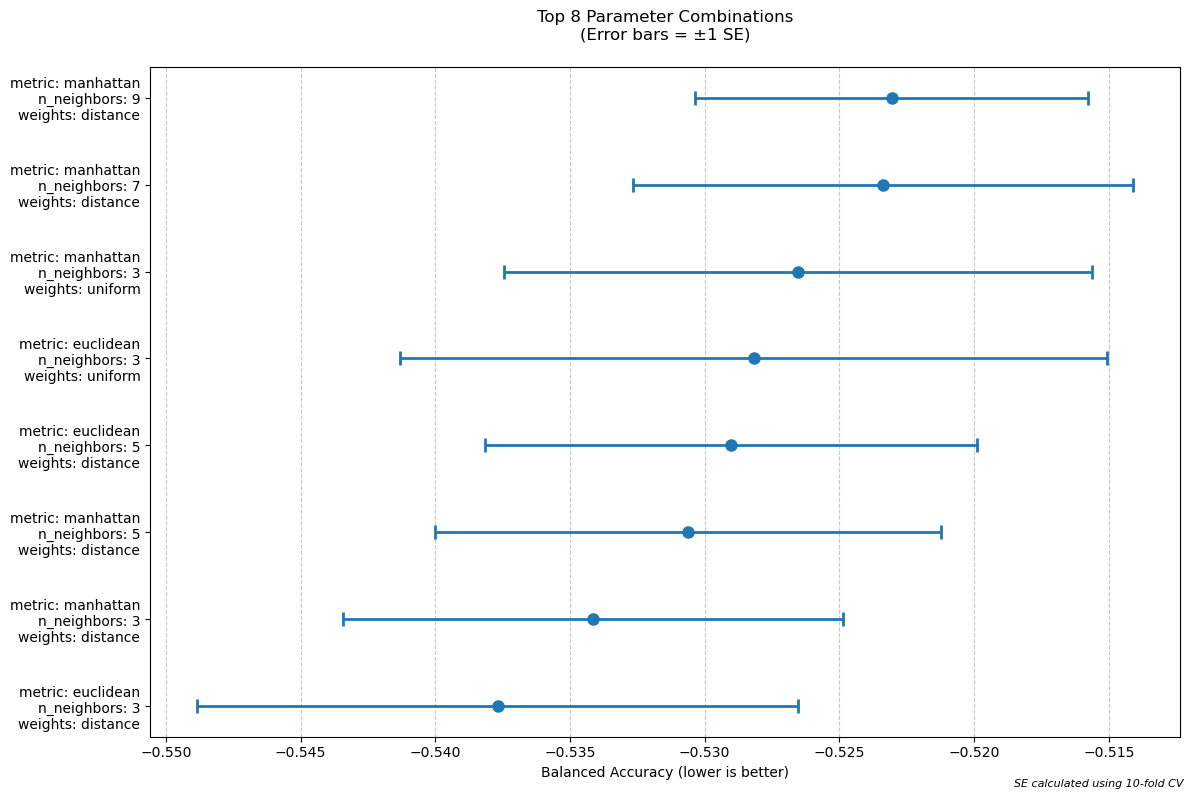


Top 8 Performance Details:
   Mean Balanced Accuracy  Std Balanced Accuracy  SE Balanced Accuracy  Rank
0                  -0.538                  0.035                 0.011     1
1                  -0.534                  0.029                 0.009     2
2                  -0.531                  0.030                 0.009     3
3                  -0.529                  0.029                 0.009     4
4                  -0.528                  0.042                 0.013     5
5                  -0.527                  0.035                 0.011     6
6                  -0.523                  0.029                 0.009     7
7                  -0.523                  0.023                 0.007     8


In [16]:
#lets try it on knn and use on the next training models
knn_performance = analyze_grid_performance(knn)
print("\nKNN Performance Table:")
print(knn_performance)
# Plot top combinations
plot_grid_performance(knn, top_n=8)

In [17]:
# Decision Tree
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

dt.fit(X, y)
cv_results['Decision Tree'] = cross_val_score(dt.best_estimator_, X, y,
                                            scoring='balanced_accuracy',
                                            cv=kf)

In [18]:
print("\nBest Decision Tree Parameters:", dt.best_params_)
print("\nDecision Tree Feature Importance:")
for feat, imp in zip(X.columns, dt.best_estimator_.feature_importances_):
    print(f"{feat}: {imp:.4f}")


Best Decision Tree Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Decision Tree Feature Importance:
age: 0.9318
hypertension: 0.0180
heart_disease: 0.0000
avg_glucose_level: 0.0115
gender_Male: 0.0000
gender_Other: 0.0000
ever_married_Yes: 0.0000
work_type_Never_worked: 0.0000
work_type_Private: 0.0000
work_type_Self-employed: 0.0000
work_type_children: 0.0000
Residence_type_Urban: 0.0000
smoking_status_formerly smoked: 0.0000
smoking_status_never smoked: 0.0387
smoking_status_smokes: 0.0000


In [19]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['Decision Tree'])
std_score = np.std(cv_results['Decision Tree'])
print(f"Decision Tree Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

Decision Tree Performance - Balanced Accuracy Mean: 0.765 Std Dev: 0.032)


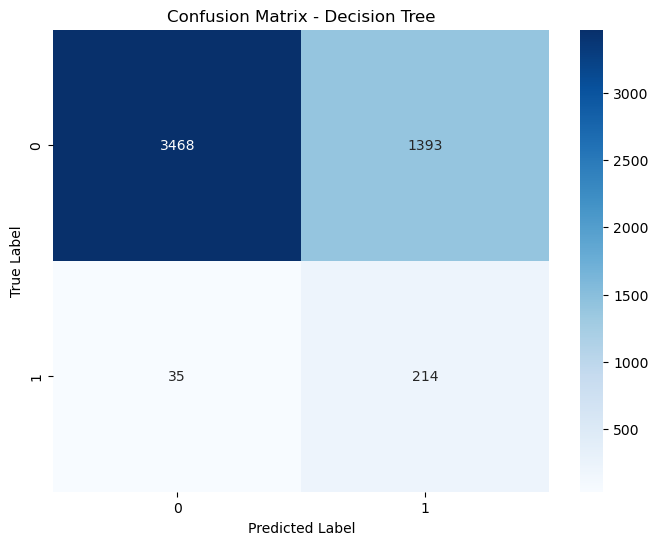


Metrics for Decision Tree:
True Positive Rate (Sensitivity/Recall): 0.859
True Negative Rate (Specificity): 0.713
Precision: 0.133
F1 Score: 0.231
Balanced Accuracy: 0.786


In [20]:
y_pred_dt = dt.predict(X)
plot_confusion_matrix(y, y_pred_dt, "Decision Tree")


Decision Tree Performance Table:
   class_weight  max_depth  min_samples_leaf  min_samples_split  \
0      balanced          3                 1                  2   
1      balanced          3                 1                  5   
2      balanced          3                 1                 10   
3      balanced          3                 2                  2   
4      balanced          3                 2                  5   
5      balanced          3                 2                 10   
6      balanced          3                 4                  2   
7      balanced          3                 4                  5   
8      balanced          3                 4                 10   
9      balanced          5                 4                  2   
10     balanced          5                 4                 10   
11     balanced          5                 4                  5   
12     balanced          5                 1                 10   
13     balanced          5  

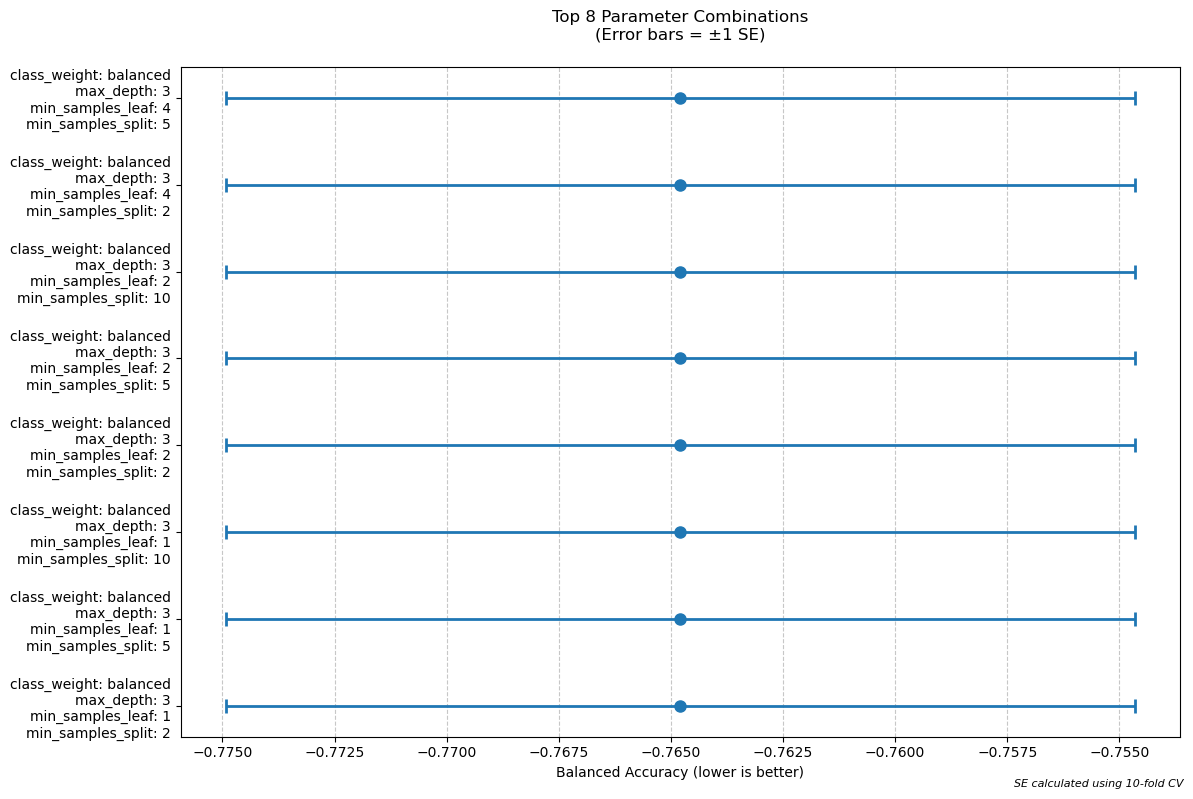


Top 8 Performance Details:
   Mean Balanced Accuracy  Std Balanced Accuracy  SE Balanced Accuracy  Rank
0                  -0.765                  0.032                  0.01     1
1                  -0.765                  0.032                  0.01     1
2                  -0.765                  0.032                  0.01     1
3                  -0.765                  0.032                  0.01     1
4                  -0.765                  0.032                  0.01     1
5                  -0.765                  0.032                  0.01     1
6                  -0.765                  0.032                  0.01     1
7                  -0.765                  0.032                  0.01     1


In [21]:
dt_performance = analyze_grid_performance(dt)
print("\nDecision Tree Performance Table:")
print(dt_performance)
# Plot top combinations
plot_grid_performance(dt, top_n=8)

In [22]:
# Random Forest
rf_params = {
    'n_estimators': [2, 3, 4],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

rf.fit(X, y)
cv_results['Random Forest'] = cross_val_score(rf.best_estimator_, X, y,
                                            scoring='balanced_accuracy',
                                            cv=kf)

In [23]:
print("\nBest Random Forest Parameters:", rf.best_params_)
print("\nRandom Forest Feature Importance:")
for feat, imp in zip(X.columns, rf.best_estimator_.feature_importances_):
    print(f"{feat}: {imp:.4f}")


Best Random Forest Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 3}

Random Forest Feature Importance:
age: 0.3368
hypertension: 0.0764
heart_disease: 0.0844
avg_glucose_level: 0.2017
gender_Male: 0.0049
gender_Other: 0.0000
ever_married_Yes: 0.1061
work_type_Never_worked: 0.0000
work_type_Private: 0.0121
work_type_Self-employed: 0.0418
work_type_children: 0.1019
Residence_type_Urban: 0.0091
smoking_status_formerly smoked: 0.0115
smoking_status_never smoked: 0.0053
smoking_status_smokes: 0.0079


In [24]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['Random Forest'])
std_score = np.std(cv_results['Random Forest'])
print(f"Random Forest Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

Random Forest Performance - Balanced Accuracy Mean: 0.722 Std Dev: 0.041)


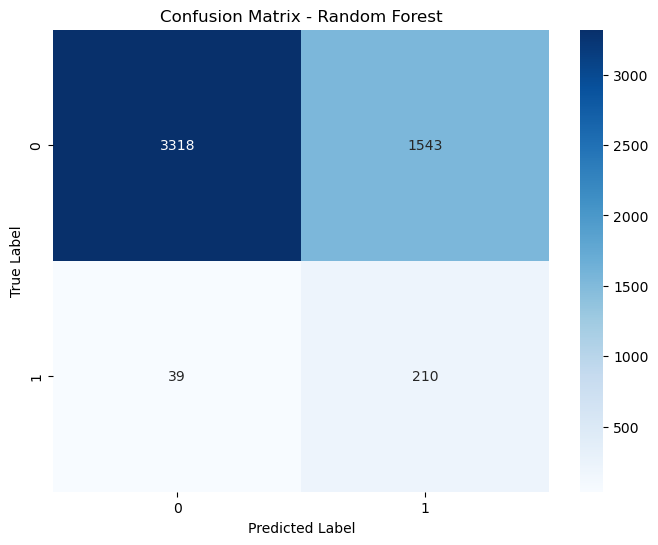


Metrics for Random Forest:
True Positive Rate (Sensitivity/Recall): 0.843
True Negative Rate (Specificity): 0.683
Precision: 0.120
F1 Score: 0.210
Balanced Accuracy: 0.763


In [25]:
y_pred_rf = rf.predict(X)
plot_confusion_matrix(y, y_pred_rf, "Random Forest")


RF Performance Table:
   class_weight  max_depth  min_samples_leaf  min_samples_split  n_estimators  \
0      balanced          5                 1                  5             3   
1      balanced          5                 2                  5             3   
2      balanced          5                 1                  5             4   
3      balanced          5                 2                  5             4   
4      balanced          5                 1                  2             3   
5      balanced          5                 2                  2             3   
6      balanced          5                 2                  2             4   
7      balanced          5                 1                  2             4   
8      balanced          5                 1                  5             2   
9      balanced          5                 2                  5             2   
10     balanced          5                 1                  2             2   
11   

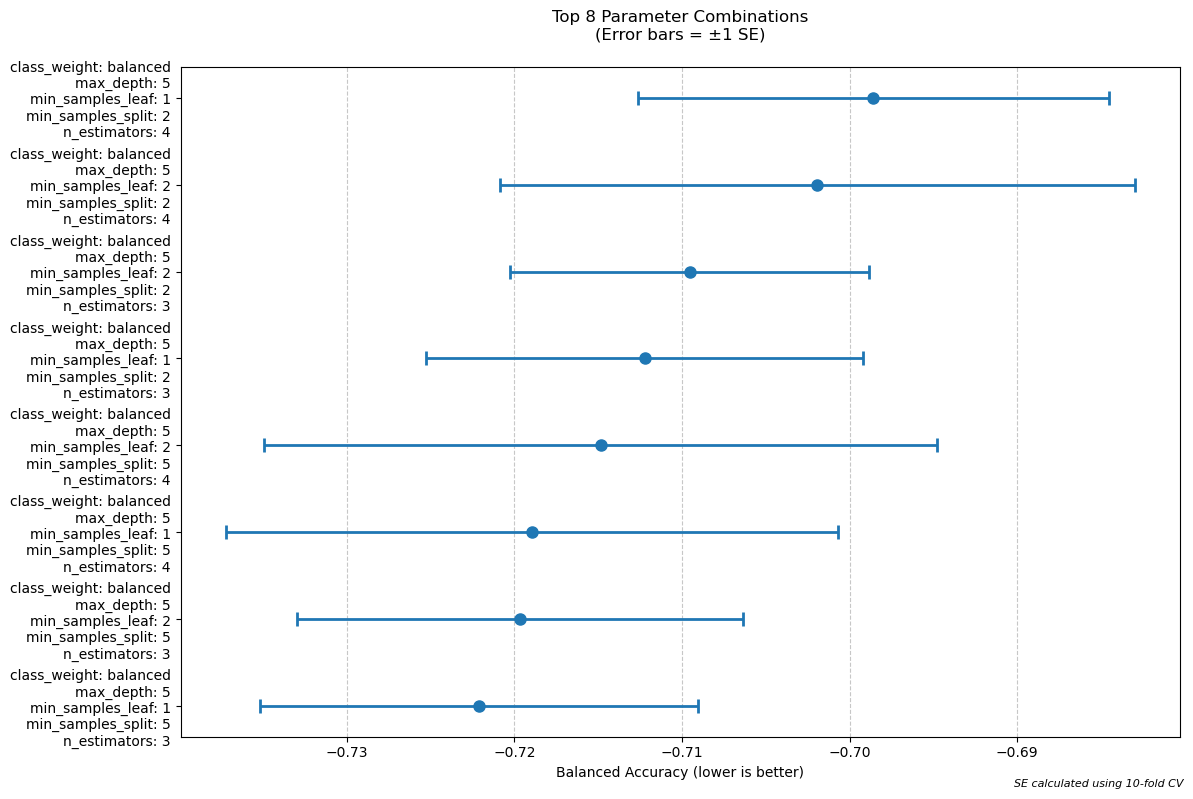


Top 8 Performance Details:
   Mean Balanced Accuracy  Std Balanced Accuracy  SE Balanced Accuracy  Rank
0                  -0.722                  0.041                 0.013     1
1                  -0.720                  0.042                 0.013     2
2                  -0.719                  0.058                 0.018     3
3                  -0.715                  0.064                 0.020     4
4                  -0.712                  0.041                 0.013     5
5                  -0.710                  0.034                 0.011     6
6                  -0.702                  0.060                 0.019     7
7                  -0.699                  0.044                 0.014     8


In [26]:
rf_performance = analyze_grid_performance(rf)
print("\nRF Performance Table:")
print(rf_performance)
# Plot top combinations
plot_grid_performance(rf, top_n=8)

In [27]:
# Gradient Boosting
gb_params = {
    'n_estimators': [2, 3, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

gb.fit(X, y)
cv_results['Gradient Boosting'] = cross_val_score(gb.best_estimator_, X, y,
                                                scoring='balanced_accuracy',
                                                cv=kf)


Gradient Boosting Performance Table:
    learning_rate  max_depth  min_samples_split  n_estimators  \
0            0.10          5                  5           200   
1            0.10          5                  2           200   
2            0.10          5                  2           100   
3            0.10          5                  5           100   
4            0.10          3                  2           200   
5            0.10          3                  2           100   
6            0.10          3                  5           100   
7            0.01          3                  2             2   
8            0.10          3                  2             2   
9            0.01          3                  2             3   
10           0.01          3                  5             3   
11           0.01          3                  5             2   
12           0.01          5                  5             2   
13           0.01          5                  5     

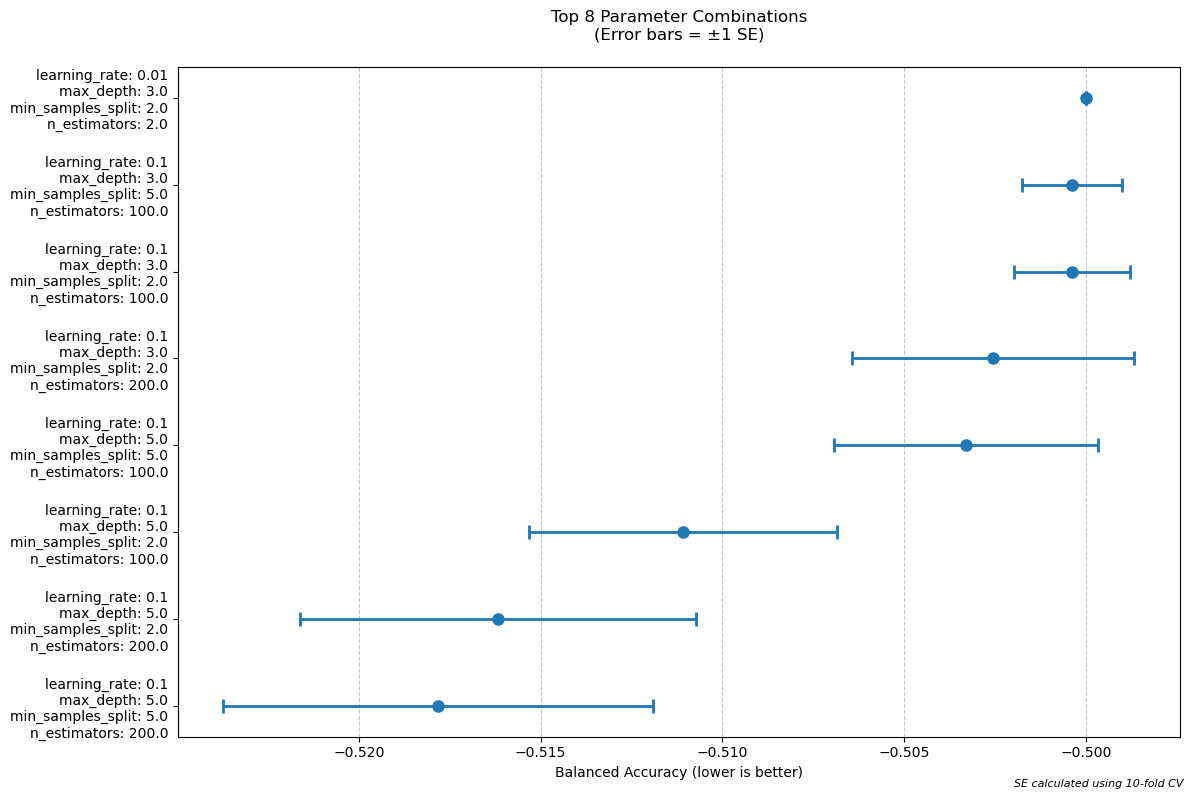


Top 8 Performance Details:
   Mean Balanced Accuracy  Std Balanced Accuracy  SE Balanced Accuracy  Rank
0                  -0.518                  0.019                 0.006     1
1                  -0.516                  0.017                 0.005     2
2                  -0.511                  0.013                 0.004     3
3                  -0.503                  0.011                 0.004     4
4                  -0.503                  0.012                 0.004     5
5                  -0.500                  0.005                 0.002     6
6                  -0.500                  0.004                 0.001     7
7                  -0.500                  0.000                 0.000     8


In [28]:
gb_performance = analyze_grid_performance(gb)
print("\nGradient Boosting Performance Table:")
print(gb_performance)
# Plot top combinations
plot_grid_performance(gb, top_n=8)

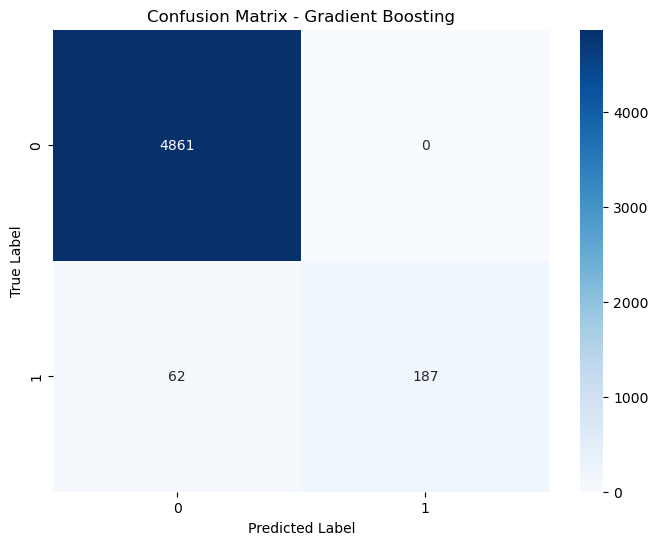


Metrics for Gradient Boosting:
True Positive Rate (Sensitivity/Recall): 0.751
True Negative Rate (Specificity): 1.000
Precision: 1.000
F1 Score: 0.858
Balanced Accuracy: 0.876


In [29]:
y_pred_gb = gb.predict(X)
plot_confusion_matrix(y, y_pred_gb, "Gradient Boosting")

In [30]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['Gradient Boosting'])
std_score = np.std(cv_results['Gradient Boosting'])
print(f"Gradient Boosting Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

Gradient Boosting Performance - Balanced Accuracy Mean: 0.518 Std Dev: 0.019)


In [31]:
# Neural Network
nn_params = {
    'hidden_layer_sizes': [(10,), (50,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

nn = GridSearchCV(
    MLPClassifier(random_state=42, max_iter=1000),
    nn_params,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

nn.fit(X, y)
cv_results['Neural Network'] = cross_val_score(nn.best_estimator_, X, y,
                                             scoring='balanced_accuracy',
                                             cv=kf)

/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perce

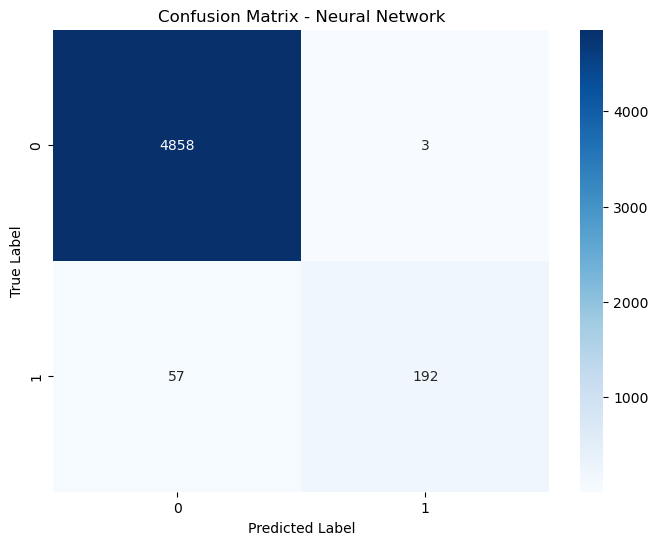


Metrics for Neural Network:
True Positive Rate (Sensitivity/Recall): 0.771
True Negative Rate (Specificity): 0.999
Precision: 0.985
F1 Score: 0.865
Balanced Accuracy: 0.885


In [32]:
y_pred_nn = nn.predict(X)
plot_confusion_matrix(y, y_pred_nn, "Neural Network")

In [33]:
# Mean and Standard Deviation of 10 different folds
mean_score = np.mean(cv_results['Neural Network'])
std_score = np.std(cv_results['Neural Network'])
print(f"Neural Network Performance - Balanced Accuracy Mean: {mean_score:.3f} Std Dev: {std_score:.3f})")

Neural Network Performance - Balanced Accuracy Mean: 0.563 Std Dev: 0.024)



Neural Network Performance Table:
   activation   alpha hidden_layer_sizes learning_rate  \
0        tanh  0.0010          (100, 50)      constant   
1        tanh  0.0010          (100, 50)      adaptive   
2        tanh  0.0001          (100, 50)      adaptive   
3        tanh  0.0001          (100, 50)      constant   
4        tanh  0.0001           (50, 25)      adaptive   
5        tanh  0.0001           (50, 25)      constant   
6        relu  0.0001          (100, 50)      constant   
7        relu  0.0001          (100, 50)      adaptive   
8        tanh  0.0010           (50, 25)      constant   
9        tanh  0.0010           (50, 25)      adaptive   
10       relu  0.0001           (50, 25)      constant   
11       relu  0.0001           (50, 25)      adaptive   
12       relu  0.0010          (100, 50)      adaptive   
13       relu  0.0010          (100, 50)      constant   
14       tanh  0.0010              (50,)      adaptive   
15       tanh  0.0010              (5

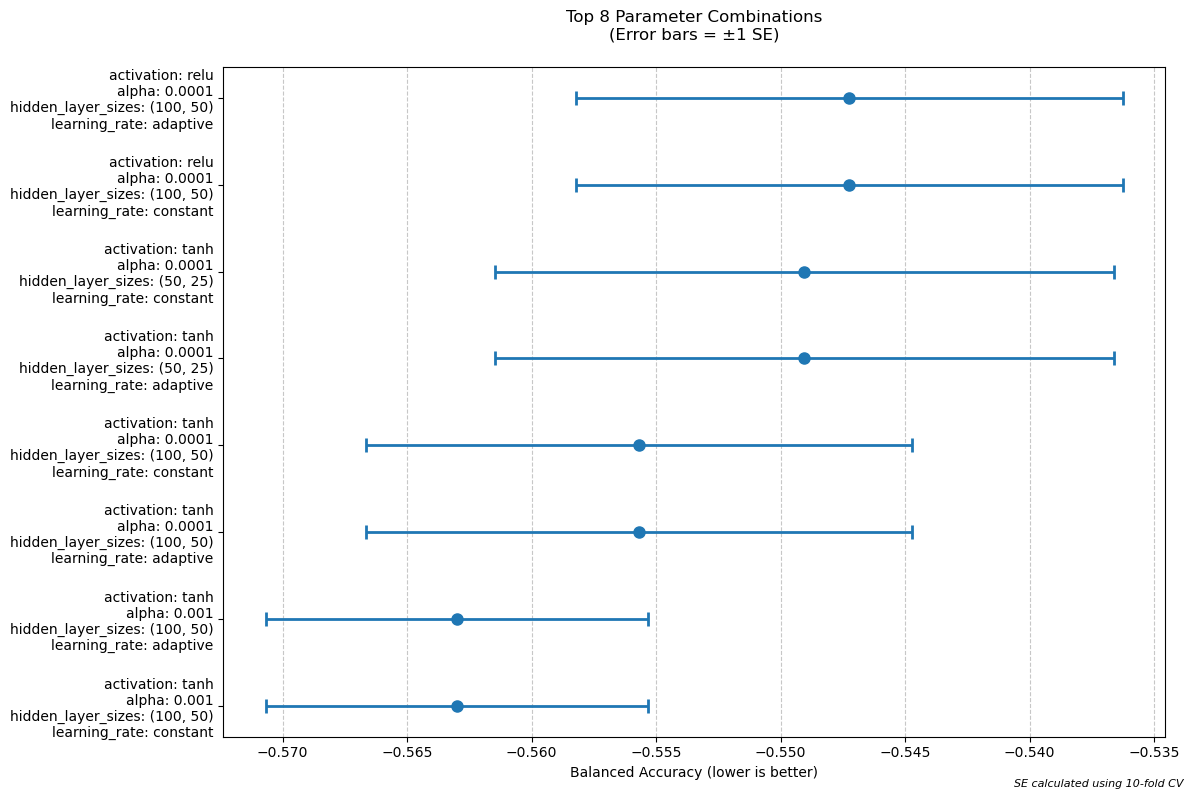


Top 8 Performance Details:
   Mean Balanced Accuracy  Std Balanced Accuracy  SE Balanced Accuracy  Rank
0                  -0.563                  0.024                 0.008     1
1                  -0.563                  0.024                 0.008     1
2                  -0.556                  0.035                 0.011     3
3                  -0.556                  0.035                 0.011     3
4                  -0.549                  0.039                 0.012     5
5                  -0.549                  0.039                 0.012     5
6                  -0.547                  0.035                 0.011     7
7                  -0.547                  0.035                 0.011     7


In [34]:
nn_performance = analyze_grid_performance(nn)
print("\nNeural Network Performance Table:")
print(nn_performance)
# Plot top combinations
plot_grid_performance(nn, top_n=8)

/tmp/ipykernel_781/528050990.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=cv_results.keys())


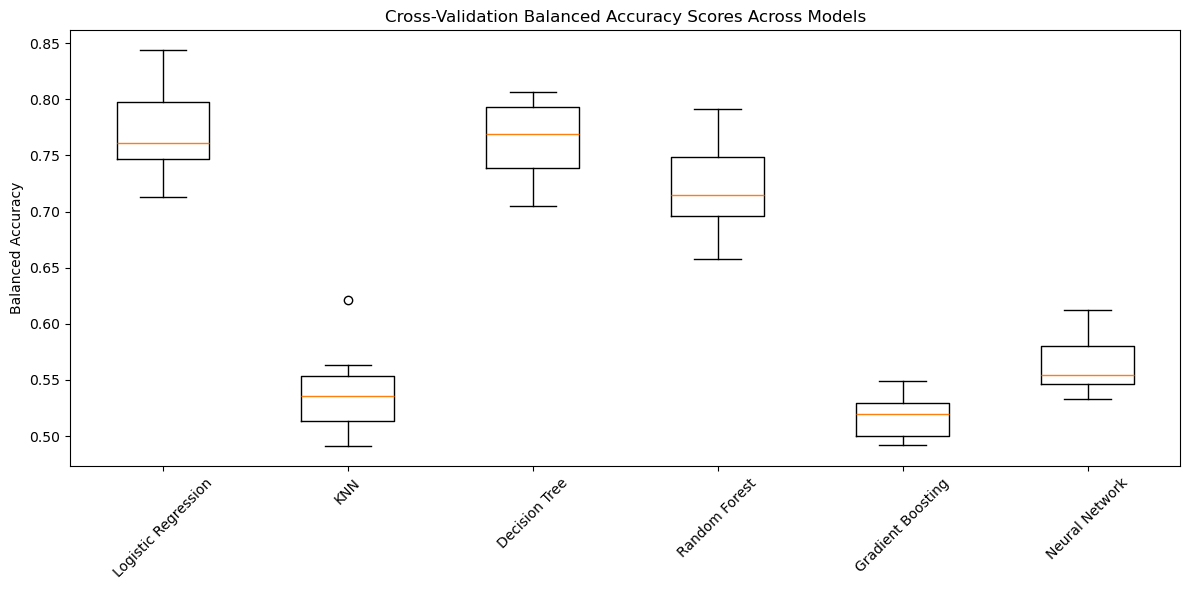

In [35]:
##compare all models
plt.figure(figsize=(12, 6))
boxplot_data = [cv_results[model] for model in cv_results.keys()]
plt.boxplot(boxplot_data, labels=cv_results.keys())
plt.title('Cross-Validation Balanced Accuracy Scores Across Models')
plt.xticks(rotation=45)
plt.ylabel('Balanced Accuracy')
plt.tight_layout()
plt.show()

In [36]:
# Print summary statistics
print("\nModel Performance Summary (Mean Balanced Accuracy ± Std):")
for model in cv_results.keys():
    scores = cv_results[model]
    print(f"{model}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Model Performance Summary (Mean Balanced Accuracy ± Std):
Logistic Regression: 0.770 ± 0.039
KNN: 0.538 ± 0.035
Decision Tree: 0.765 ± 0.032
Random Forest: 0.722 ± 0.041
Gradient Boosting: 0.518 ± 0.019
Neural Network: 0.563 ± 0.024


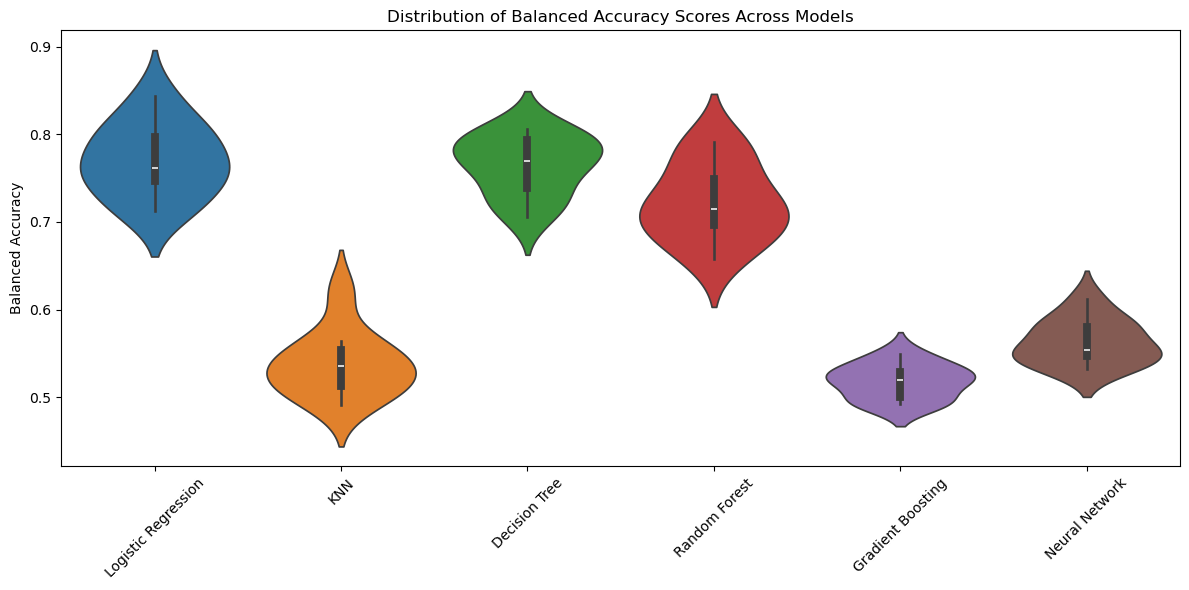

In [37]:
# Create violin plot
plt.figure(figsize=(12, 6))
violin_data = pd.DataFrame(cv_results)
sns.violinplot(data=violin_data)
plt.title('Distribution of Balanced Accuracy Scores Across Models')
plt.xticks(rotation=45)
plt.ylabel('Balanced Accuracy')
plt.tight_layout()
plt.show()

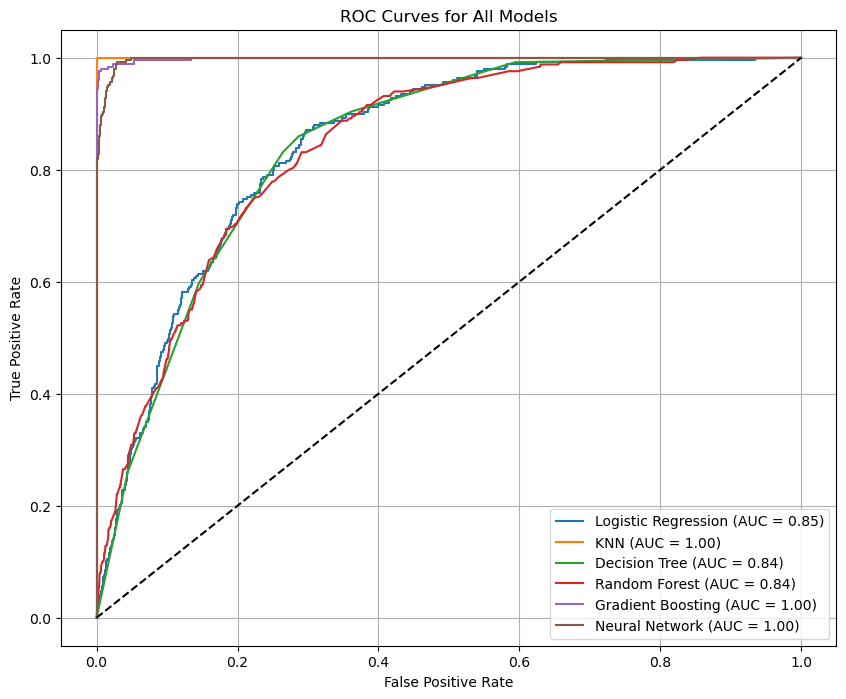

In [38]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
models = {
    'Logistic Regression': lr,
    'KNN': knn.best_estimator_,
    'Decision Tree': dt.best_estimator_,
    'Random Forest': rf.best_estimator_,
    'Gradient Boosting': gb.best_estimator_,
    'Neural Network': nn.best_estimator_
}

for name, model in models.items():
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<Figure size 3000x3000 with 0 Axes>

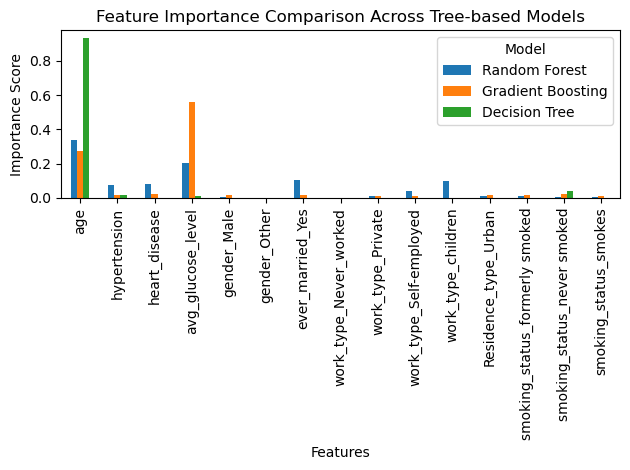

In [39]:
# Feature importance comparison for tree-based models
def plot_feature_importance_comparison():
    importances = {
        'Random Forest': rf.best_estimator_.feature_importances_,
        'Gradient Boosting': gb.best_estimator_.feature_importances_,
        'Decision Tree': dt.best_estimator_.feature_importances_
    }

    importance_df = pd.DataFrame(importances, index=X.columns)

    plt.figure(figsize=(30, 30))
    importance_df.plot(kind='bar')
    plt.title('Feature Importance Comparison Across Tree-based Models')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

plot_feature_importance_comparison()